In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import mean, stddev, col, log
from pyspark.sql.functions import to_date, dayofweek, to_timestamp
from pyspark.sql import types 
from pyspark.sql.functions import col, udf
from datetime import datetime
from pyspark.sql.types import DateType
from pyspark.sql.functions import year, month
from pyspark.sql.functions import dayofmonth, weekofyear
from pyspark.sql.functions import split, explode
from pyspark.sql.functions import coalesce, first, lit
from pyspark.ml.feature import Binarizer
from pyspark.ml.feature import Bucketizer
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.sql.functions import regexp_extract, col

In [3]:
from modules.pyspark import CPySpark
from pyspark.sql import Row, SQLContext

In [4]:
spark = CPySpark(session=True, sql=True)

In [5]:
spark = spark.session

In [6]:
df = spark.read.csv("./data/2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)

df_sub = df.select('STREETNUMBERNUMERIC', 'FIREPLACES', 
                   'LOTSIZEDIMENSIONS', 'LISTTYPE', 'ACRES', 
                   'ASSUMABLEMORTGAGE', 'SalesClosePrice', 'ListPrice',
                   'DAYSONMARKET')
df_sub.show(5)

+-------------------+----------+-----------------+---------------+-----+-----------------+---------------+---------+------------+
|STREETNUMBERNUMERIC|FIREPLACES|LOTSIZEDIMENSIONS|       LISTTYPE|ACRES|ASSUMABLEMORTGAGE|SalesClosePrice|ListPrice|DAYSONMARKET|
+-------------------+----------+-----------------+---------------+-----+-----------------+---------------+---------+------------+
|              11511|         0|          279X200|Exclusive Right| 1.28|             null|         143000|   139900|          10|
|              11200|         0|          100x140|Exclusive Right| 0.32|             null|         190000|   210000|           4|
|               8583|         0|          120x296|Exclusive Right|0.822|    Not Assumable|         225000|   225000|          28|
|               9350|         1|          208X208|Exclusive Right| 0.94|             null|         265000|   230000|          19|
|               2915|         1|          116x200|Exclusive Right|  0.0|             null|

In [7]:
df_sub = df_sub.drop(*['STREETNUMBERNUMERIC', 'LOTSIZEDIMENSIONS'])
df_sub.show(5)

+----------+---------------+-----+-----------------+---------------+---------+------------+
|FIREPLACES|       LISTTYPE|ACRES|ASSUMABLEMORTGAGE|SalesClosePrice|ListPrice|DAYSONMARKET|
+----------+---------------+-----+-----------------+---------------+---------+------------+
|         0|Exclusive Right| 1.28|             null|         143000|   139900|          10|
|         0|Exclusive Right| 0.32|             null|         190000|   210000|           4|
|         0|Exclusive Right|0.822|    Not Assumable|         225000|   225000|          28|
|         1|Exclusive Right| 0.94|             null|         265000|   230000|          19|
|         1|Exclusive Right|  0.0|             null|         249900|   239900|          21|
+----------+---------------+-----+-----------------+---------------+---------+------------+
only showing top 5 rows



In [8]:
df_sub.select(['ASSUMABLEMORTGAGE']).distinct().show()

+-------------------+
|  ASSUMABLEMORTGAGE|
+-------------------+
|  Yes w/ Qualifying|
| Information Coming|
|               null|
|Yes w/No Qualifying|
|      Not Assumable|
+-------------------+



In [9]:
df_sub.count()

5000

In [10]:
yes_values = ['Yes w/ Qualifying', 'Yes w/No Qualifying']

In [11]:
text_filter = ~df_sub['ASSUMABLEMORTGAGE'].isin(yes_values) | df_sub['ASSUMABLEMORTGAGE'].isNull()
df_sub = df.where(text_filter) 

In [12]:
df_sub.count()

4976

/home/manhcuong/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

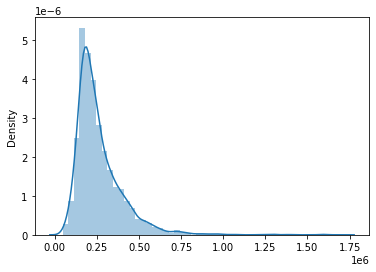

In [13]:
df_scp = df_sub.select('SalesClosePrice').toPandas()
sns.distplot(df_scp)

In [14]:
df_sub = df_sub.withColumn('log_ScalesClosePrice', log(col('SalesClosePrice')))

In [15]:
df_sub.count()

4976

In [16]:
df_sub

DataFrame[No: int, MLSID: string, StreetNumberNumeric: int, streetaddress: string, STREETNAME: string, PostalCode: int, StateOrProvince: string, City: string, SalesClosePrice: int, LISTDATE: string, LISTPRICE: int, LISTTYPE: string, OriginalListPrice: int, PricePerTSFT: double, FOUNDATIONSIZE: int, FENCE: string, MapLetter: string, LotSizeDimensions: string, SchoolDistrictNumber: string, DAYSONMARKET: int, offmarketdate: string, Fireplaces: int, RoomArea4: string, roomtype: string, ROOF: string, RoomFloor4: string, PotentialShortSale: string, PoolDescription: string, PDOM: int, GarageDescription: string, SQFTABOVEGROUND: int, Taxes: int, RoomFloor1: string, RoomArea1: string, TAXWITHASSESSMENTS: double, TAXYEAR: int, LivingArea: int, UNITNUMBER: string, YEARBUILT: int, ZONING: string, STYLE: string, ACRES: double, CoolingDescription: string, APPLIANCES: string, backonmarketdate: string, ROOMFAMILYCHAR: string, RoomArea3: string, EXTERIOR: string, RoomFloor3: string, RoomFloor2: string,

In [17]:
df_sub.select('log_ScalesClosePrice').toPandas()

,log_ScalesClosePrice
0,11.870600
1,12.154779
2,12.323856
3,12.487485
4,12.428816
...,...
4971,13.591116
4972,13.598598
4973,13.670485
4974,13.864506


/home/manhcuong/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

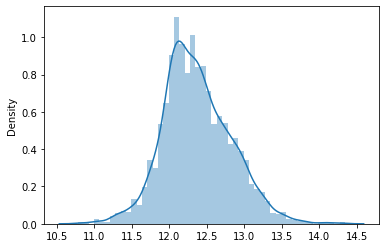

In [18]:
sns.distplot(df_sub.select('log_ScalesClosePrice').toPandas())

In [19]:
mean_val = df_sub.agg({'log_ScalesClosePrice': 'mean'}).collect()[0][0]

In [20]:
stddev_val = df_sub.agg({'log_ScalesClosePrice': 'stddev'}).collect()[0][0]

In [21]:
low_bound = mean_val - (3 * stddev_val)
upper_bound = mean_val + (3 * stddev_val)

In [22]:
df_sub = df_sub.where((df_sub['log_ScalesClosePrice'] < upper_bound) & (df_sub['log_ScalesClosePrice'] > low_bound))

In [23]:
df_sub.count()

4946

In [24]:
df_sub.select('log_ScalesClosePrice').toPandas()

,log_ScalesClosePrice
0,11.870600
1,12.154779
2,12.323856
3,12.487485
4,12.428816
...,...
4941,13.586097
4942,13.567049
4943,13.591116
4944,13.598598


/home/manhcuong/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

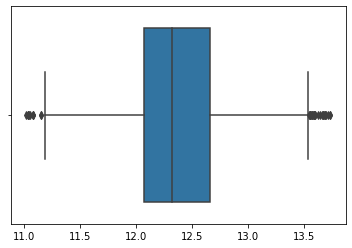

In [25]:
sns.boxplot(df_sub.select('log_ScalesClosePrice').toPandas().values)

Xóa dữ liệu NA/NULL

In [26]:
# df_sub = df_sub.dropna(how='all', subset=['ListPrice', 'SalesClosePrice']) # drop with 2 features in subset are null
# df_sub = df_sub.dropna() # drop any record with null value
# df_sub = df_sub.dropna(thresh=2) # drop records with more than 2 null features

In [27]:
df_sub.toPandas()

,No,MLSID,StreetNumberNumeric,streetaddress,STREETNAME,PostalCode,StateOrProvince,City,SalesClosePrice,LISTDATE,...,RoomFloor7,RoomArea8,RoomFloor8,Bedrooms,SQFTBELOWGROUND,AssumableMortgage,AssociationFee,ASSESSMENTPENDING,AssessedValuation,log_ScalesClosePrice
0,1,RMLS,11511,11511 Stillwater Blvd N,Stillwater,55042,MN,LELM - Lake Elmo,143000,7/15/2017 0:00,...,None,None,None,3,0,None,0,Unknown,0.0,11.870600
1,2,RMLS,11200,11200 31st St N,31st,55042,MN,LELM - Lake Elmo,190000,10/9/2017 0:00,...,Main,11x11,Lower,4,960,None,0,Unknown,0.0,12.154779
2,3,RMLS,8583,8583 Stillwater Blvd N,Stillwater,55042,MN,LELM - Lake Elmo,225000,6/26/2017 0:00,...,None,None,None,2,0,Not Assumable,0,No,0.0,12.323856
3,4,RMLS,9350,9350 31st St N,31st,55042,MN,LELM - Lake Elmo,265000,8/25/2017 0:00,...,None,None,None,2,348,None,0,Unknown,0.0,12.487485
4,5,RMLS,2915,2915 Inwood Ave N,Inwood,55042,MN,LELM - Lake Elmo,249900,9/12/2017 0:00,...,Lower,None,None,3,1026,None,0,No,0.0,12.428816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4941,4994,RMLS,10869,10869 Bentwater Ln,Bentwater,55129,MN,WB - Woodbury,795000,7/21/2017 0:00,...,Upper,15x13,Lower,6,2295,None,80,No,0.0,13.586097
4942,4995,RMLS,10271,10271 Stony Creek Dr,Stony Creek,55129,MN,WB - Woodbury,780000,6/21/2017 0:00,...,Upper,15x12,Upper,5,1896,None,480,No,0.0,13.567049
4943,4996,RMLS,4933,4933 Sunflower Dr,Sunflower,55129,MN,WB - Woodbury,799000,8/1/2017 0:00,...,Lower,None,None,3,1686,None,102,No,86.0,13.591116
4944,4997,RMLS,10746,10746 Watersedge Ln,Watersedge,55129,MN,WB - Woodbury,805000,8/1/2017 0:00,...,Lower,13x11,Lower,5,2220,None,80,No,0.0,13.598598


Xóa dữ liệu trùng lắp

# Data Cleaning

Tìm min max value

In [29]:
df_sub.agg({'SalesClosePrice': 'max'}).collect()

[Row(max(SalesClosePrice)=920000)]

In [33]:
df_sub.agg({'SalesClosePrice': 'min'}).collect()

[Row(min(SalesClosePrice)=61000)]

In [31]:
max_price = df_sub.agg({'SalesClosePrice': 'max'}).collect()[0][0]
min_price = df_sub.agg({'SalesClosePrice': 'min'}).collect()[0][0]

In [32]:
min_price, max_price

(61000, 920000)

In [34]:
df_sub = df_sub.withColumn('scaled_price', (df['SalesClosePrice'] - min_price) / (max_price - min_price))

In [35]:
df_sub.agg({'scaled_price': 'max'}).collect()

[Row(max(scaled_price)=1.0)]

In [36]:
df_sub.agg({'scaled_price': 'min'}).collect()

[Row(min(scaled_price)=0.0)]

In [37]:
df_sub.select('scaled_price').show(5)

+-------------------+
|       scaled_price|
+-------------------+
|0.09545983701979045|
|0.15017462165308498|
| 0.1909196740395809|
|0.23748544819557627|
|  0.219906868451688|
+-------------------+
only showing top 5 rows



In [38]:
def min_max_scaler(df, cols_to_scale):
    # Takes a dataframe and list of columns to minmax scale. Returns a dataframe.
    for col in cols_to_scale:
        # Define min and max values and collect them
        max_values = df.agg({col: 'max'}).collect()[0][0]
        min_values = df.agg({col: 'min'}).collect()[0][0]
        new_column_name = 'scaled_' + col
        # Create a new column based off the scaled data
        df = df.withColumn(new_column_name, 
                      (df[col] - min_values) / (max_values - min_values))
    return df

In [40]:
cols_to_scale = ['ListPrice']
df_sub = min_max_scaler(df_sub, cols_to_scale)
df_sub[['ListPrice', 'scaled_ListPrice']].show(3)

+---------+-------------------+
|ListPrice|   scaled_ListPrice|
+---------+-------------------+
|   139900| 0.1099009900990099|
|   210000|0.18701870187018702|
|   225000|0.20352035203520352|
+---------+-------------------+
only showing top 3 rows



## Standard Scaling

In [42]:
# mean_days = df_sub.agg({'DAYSONMARKET', 'mean'}).collect()[0][0]
# stddev_days = df_sub.agg({'DAYSONMARKET', 'stddev'}).collect()[0][0]

# df_sub = df_sub.withColumn('ztrans_days', (df_sub['DAYSONMARKET'] - mean_days)/stddev_days)


Kiểm tra dữ liệu thiếu

Hiển thị dữ liệu thiếu


In [43]:
roof = df[['ROOF']]
roof.where(df['ROOF'].isNull()).count()

765

In [45]:
roof_df = roof.toPandas()


<AxesSubplot:>

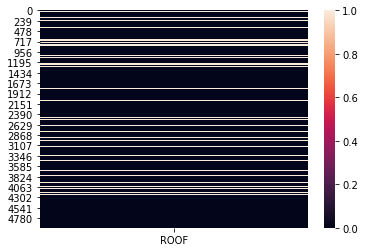

In [47]:
sns.heatmap(data=roof_df.isnull())

In [48]:
sales_close_price = df[['SalesClosePrice']]
sales_close_price.where(df['SalesClosePrice'].isNotNull()).count()

5000

<AxesSubplot:>

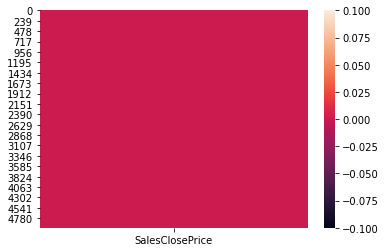

In [49]:
sns.heatmap(data=sales_close_price.toPandas().isnull())

In [50]:
def column_dropper(df, threshold):
    # Takes a dataframe and threshold for missing values. 
    # Returns a dataframe.
    total_records = df.count()
    for col in df.columns:
        # Calculate the percentage of missing values
        missing = df.where(df[col].isNull()).count()
        missing_percent = missing / total_records
        # Drop column if percent of missing is more than threshold
        if missing_percent > threshold:
            df = df.drop(col)
    return df

In [51]:
df = column_dropper(df, 0.7)

In [52]:
df.toPandas()

,No,MLSID,StreetNumberNumeric,streetaddress,STREETNAME,PostalCode,StateOrProvince,City,SalesClosePrice,LISTDATE,...,RoomArea7,RoomFloor7,RoomArea8,RoomFloor8,Bedrooms,SQFTBELOWGROUND,AssumableMortgage,AssociationFee,ASSESSMENTPENDING,AssessedValuation
0,1,RMLS,11511,11511 Stillwater Blvd N,Stillwater,55042,MN,LELM - Lake Elmo,143000,7/15/2017 0:00,...,None,None,None,None,3,0,None,0,Unknown,0.0
1,2,RMLS,11200,11200 31st St N,31st,55042,MN,LELM - Lake Elmo,190000,10/9/2017 0:00,...,10x11,Main,11x11,Lower,4,960,None,0,Unknown,0.0
2,3,RMLS,8583,8583 Stillwater Blvd N,Stillwater,55042,MN,LELM - Lake Elmo,225000,6/26/2017 0:00,...,None,None,None,None,2,0,Not Assumable,0,No,0.0
3,4,RMLS,9350,9350 31st St N,31st,55042,MN,LELM - Lake Elmo,265000,8/25/2017 0:00,...,None,None,None,None,2,348,None,0,Unknown,0.0
4,5,RMLS,2915,2915 Inwood Ave N,Inwood,55042,MN,LELM - Lake Elmo,249900,9/12/2017 0:00,...,14x13,Lower,None,None,3,1026,None,0,No,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,RMLS,4933,4933 Sunflower Dr,Sunflower,55129,MN,WB - Woodbury,799000,8/1/2017 0:00,...,12x14,Lower,None,None,3,1686,None,102,No,86.0
4996,4997,RMLS,10746,10746 Watersedge Ln,Watersedge,55129,MN,WB - Woodbury,805000,8/1/2017 0:00,...,14x14,Lower,13x11,Lower,5,2220,None,80,No,0.0
4997,4998,RMLS,10721,10721 Watersedge Ln,Watersedge,55129,MN,WB - Woodbury,865000,3/27/2017 0:00,...,13x12,Upper,15x13,Upper,4,1861,None,86,No,0.0
4998,4999,RMLS,4981,4981 Sunflower Pl,Sunflower,55129,MN,WB - Woodbury,1050216,5/24/2017 0:00,...,13.6x11,Upper,12x11,Upper,4,0,None,105,Unknown,0.0


# Feature enginerring